In [2]:
import os
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('/data/home/waitma/antibody_proj/peds2019/')

from ablstm import ModelLSTM

from anarci import anarci, number
import re
from abnumber import Chain

In [4]:
# Model initial.
model_data_path = '/data/home/waitma/antibody_proj/peds2019/saved_models/tmp/model_tmp.npy'
pred_model = ModelLSTM(embedding_dim=64, hidden_dim=64, device='cuda', gapped=True, fixed_len=True)
pred_model.load(fn=model_data_path)

In [5]:
# Test the model.
test_data = '/data/home/waitma/antibody_proj/peds2019/data/sample/human_test.txt'
pred_model.eval(test_data)

100%|| 76515/76515 [00:08<00:00, 9192.26seq/s]


array([0.8364956 , 0.30142805, 0.8389481 , ..., 0.5885746 , 0.5888609 ,
       0.41556427], dtype=float32)

In [6]:
# Deal sample data
sample_fpath = '/data/home/waitma/antibody_proj/antidiff/checkpoints/batch_one_sample_2023_11_16__22_44_23/sample_humanization_result.csv'
sample_df = pd.read_csv(sample_fpath)

new_columns_name = {
    'Specific': 'Specific',
    'name': 'name',
    'HSEQ': 'hseq',
    'LSEQ': 'lseq'
}

sample_df = sample_df.rename(columns=new_columns_name)
sample_human_df = sample_df[sample_df['Specific'] == 'humanization'].reset_index(drop=True)
sample_human_df.head()

,Specific,name,hseq,lseq,Unnamed: 4
0,humanization,3A3human_0,EVQLVESGGGLVQPGGSLRLSCVASGFTFSNFWMNWVRQAPGKGLE...,DIQMTQSPSPLSASVGDRANITCRASQDVSTDLGWYQQKPGKAPKV...,NaN
1,humanization,MAK195human_0,QVQLVESGGGVVQPGGSLRLSCAASGFSLTDYGVAWVRQPPGKGLE...,DIQMAQSPSSLSASVGDRVTITCRASQAVSSALTWYQQIPGKSPKL...,NaN
2,humanization,31#human_0,EVQLVQSGAEVKKPGESLKISCKASGYTFTDYWIGWVRQMPGKGLE...,DIVMTQSPDSLAVSLGERATISCKSSQSLLNTNSQKNYIAWYQQKP...,NaN
3,humanization,56#human_0,QVQLQESGPRLVEPSETLSLTCTVSGYSITSDYDWGWIRQPPGRGL...,DTLLTQSPDHLSVTLGERATISCRASQNIGTSLNWYQQKPGQSPKR...,NaN
4,humanization,74#human_0,EVQLVQSGAEVKKPGESLKISCQVSGYTFINYWIGWVRQMPGKGLE...,DIVMTQSPDSLTVSVGERATINCRSSQTLLNSNTQKNYVTWYQQKA...,NaN


In [9]:
filter_fpath = '/data/home/waitma/antibody_proj/antidiff/checkpoints/batch_one_sample_2023_11_16__22_44_23/filter_humanization_result.csv'
filter_human_df = pd.read_csv(filter_fpath)

,Specific,name,hseq,lseq,Unnamed: 4
0,humanization,3A3human_0,EVQLVESGGGLVQPGGSLRLSCVASGFTFSNFWMNWVRQAPGKGLE...,DIQMTQSPSPLSASVGDRANITCRASQDVSTDLGWYQQKPGKAPKV...,NaN
1,humanization,31#human_0,EVQLVQSGAEVKKPGESLKISCKASGYTFTDYWIGWVRQMPGKGLE...,DIVMTQSPDSLAVSLGERATISCKSSQSLLNTNSQKNYIAWYQQKP...,NaN
2,humanization,74#human_0,EVQLVQSGAEVKKPGESLKISCQVSGYTFINYWIGWVRQMPGKGLE...,DIVMTQSPDSLTVSVGERATINCRSSQTLLNSNTQKNYVTWYQQKA...,NaN
3,humanization,SC73.38human_0,QVHLVQSGAEVKKPGASVKVSCKASGYSFTGYTIHWVRQAPGQGLE...,EIVMTQSPATLSVSPGETATLSCRASQSISNNLVWYQQKPDQAPRL...,NaN
4,humanization,SC73.39human_0,QVQLVQSGAEVKKPGASVKVSCRTSGYSFTNYNFAWVRQAPRQGLE...,DIVMTQSPDSLAVSLGERATIKCKSSQSLLNSSNQKNYLAWYQQKP...,NaN
...,...,...,...,...,...
111,humanization,RK22human_0,EVQLVQSGVEVKKPGESLKISCKGSGYTFTSYWIGWVRQMPGKGLE...,DIVVTQSPDSLAVSLGERATINCKSSQSLLNSANQKNYLAWYQQKP...,NaN
112,humanization,49G8human_0,QVQLVQSGSEVKKPGASVKVSCQASGYTFADYEIHWMRQAPGQGPE...,DVVVTQSPLSLPVTLGQPASISCRSSQSIVHSNGNTYLDWFQQRPG...,NaN
113,humanization,mu515H7human_0,EVQLVESGGGLVQPGGSLRLSCATSGFTFTDNYMDWVRQAPGKGLE...,IVLTQSPDSLAVSLGERATINCKSSQSLFNSRTRKNYLTWYQQKPG...,NaN
114,humanization,mu16B5human_0,QVRLVQSGAEVKKPGASVGVSCKASGFNIKDIYIHWVRQVPGQGPE...,DIVMTQFPNSLAVSLGERATINCKSSQSLLNSRTRKNYLSWYQKKA...,NaN


In [11]:
# Need to trans data type >>> aho encode.

# Deal Heavy seq.
h_seq_df = filter_human_df['hseq']
data = []
for idx, a_seq in enumerate(h_seq_df):
    data.append((f'{idx}', a_seq))

# single_data = [('1', single_h_seq), ('2', single_h_seq)]
h_results = anarci(data, scheme='aho', output=False)
h_aho_seq_list = []
h_seq_results = h_results[0]
for seq_list in h_seq_results:
    re_seq = seq_list[0][0]
    str_re_seq = str(re_seq)
    matches =  re.findall(r"'([A-Z\-])'", str_re_seq)
    aho_seq = '-' + ''.join(matches)
    if len(aho_seq) != 150:
        pad_count = 150 - len(aho_seq)
        aho_seq = aho_seq + '-' * pad_count
    h_aho_seq_list.append(aho_seq)

# Save h_aho_seq_list
save_path = './tmp_filter_h_aho.txt'
with open(save_path, 'w') as f:
    for seq in h_aho_seq_list:
        f.write(seq + '\n')

In [6]:
# Deal Light seq.
# l_seq_df = sample_human_df['lseq']
# data = []
# for idx, a_seq in enumerate(l_seq_df):
#     data.append((f'{idx}', a_seq))

# # single_data = [('1', single_h_seq), ('2', single_h_seq)]
# l_results = anarci(data, scheme='aho', output=False)
# l_aho_seq_list = []
# l_seq_results = l_results[0]
# for seq_list in l_seq_results:
#     re_seq = seq_list[0][0]
#     str_re_seq = str(re_seq)
#     matches =  re.findall(r"'([A-Z\-])'", str_re_seq)
#     aho_seq = '-' + ''.join(matches)
#     if len(aho_seq) != 150:
#         pad_count = 150 - len(aho_seq)
#         aho_seq = aho_seq + '-' * pad_count
#     l_aho_seq_list.append(aho_seq)

# # Save h_aho_seq_list
# save_path = './tmp_test_l_aho.txt'
# with open(save_path, 'w') as f:
#     for seq in l_aho_seq_list:
#         f.write(seq + '\n')

In [7]:
# Predict Score。

# Heavy score
h_score = pred_model.eval('./tmp_test_h_aho.txt')

# Light score
filter_h_score = pred_model.eval('./tmp_filter_h_aho.txt')

100%|| 116/116 [00:00<00:00, 8789.75seq/s]


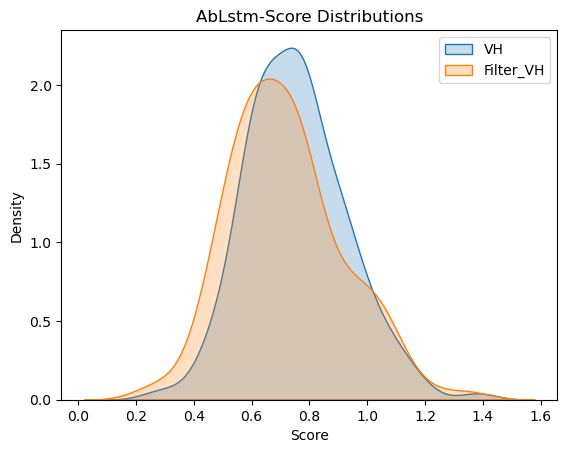

In [8]:
sns.kdeplot(h_score, fill=True, label='VH')
sns.kdeplot(filter_h_score, fill=True, label='Filter_VH')

plt.xlabel("Score")
plt.ylabel("Density")
plt.title("AbLstm-Score Distributions")
plt.legend()

In [21]:
# Deal experimental data
# lab_data_fpath = '/data/home/waitma/antibody_proj/antidiff/data/lab_data/humanization_pair_data.xlsx'
filter_lab_save_fpath = '/data/home/waitma/antibody_proj/antidiff/data/lab_data/humanization_pair_data_filter.csv'
lab_df = pd.read_csv(filter_lab_save_fpath)
lab_df
lab_humanized_df = lab_df[lab_df['type'] != 'mouse']
lab_humanized_df['h_seq']

1      EVQLVESGGGLVQPGGSLRLSCAASGFTFSNFWMDWVRQAPGKGLE...
3      EVQLQESGPGLVKPSETLSLTCTVSGGSISDYGVNWIRQPPGKGLE...
5      QVQLVQSGAEVKKPGSSVKVSCKASGYTFTDYWMNWVRLAPGQGLE...
7      QVQLQESGPGLVKPSQTLSLTCTVSGYFNSITSDYDWHWIRHHPGK...
9      QVQLVQSGAEVKKPGSSVKVSCKASGYTFINYWMNWVRQAPGQGLE...
                             ...                        
689    QVQLVQSGAEVKKPGASVKVSCKASGYTFTNYWIHWVRQAPGQGLE...
691    EVQLVESGGGLVQPGRSLRLSCTASGFTFTDNYMSWVRQAPGKGLE...
693    QVQLVQSGAEVKKPGATVKISCKVSGFNIKDIYMHWVQQAPGKGLE...
695    QVQLVQSGSELKKPGASVKVSCKASGYTFTNYGMHWVRQAPGQGLE...
697    EVQLVESGGGLVQPGRSLRLSCTASGFTFSKYAMSWVRQAPGKGLE...
Name: h_seq, Length: 349, dtype: object

In [33]:
# Construct a function for data type transformation
def seq_to_aho(seq_series, save_path):
    data = []
    for idx, a_seq in enumerate(seq_series):
        if 'X' in a_seq:
            continue
        else:
            data.append((f'{idx}', a_seq))

    results = anarci(data, scheme='aho', output=False)
    aho_seq_list = []
    seq_results = results[0]
    for seq_list in seq_results:
        re_seq = seq_list[0][0]
        str_re_seq = str(re_seq)
        matches =  re.findall(r"'([A-Z\-])'", str_re_seq)
        aho_seq = '-' + ''.join(matches)
        if len(aho_seq) != 150:
            pad_count = 150 - len(aho_seq)
            aho_seq = aho_seq + '-' * pad_count
        aho_seq_list.append(aho_seq)

    # Save to txt for model.
    with open(save_path, 'w') as f:
        for seq in aho_seq_list:
            f.write(seq + '\n')

In [34]:
# Deal Heavy seq.
h_seq_df = lab_humanized_df['h_seq'].copy().reset_index(drop=True)
# for seq in h_seq_df:
#     print(seq)
#     if 'B' in seq:
#         print(seq)
seq_to_aho(h_seq_df, './lab_h_aho.txt')

# Deal Light seq.
# l_seq_df = lab_humanized_df['LC sequence'].copy().reset_index(drop=True)
# seq_to_aho(l_seq_df, './lab_l_aho.txt')


In [142]:
test_seq = 'MKHLWFFLLLVAAPRWVLSQVQLVQSGAEVKKPGASVKVSCKASGYSFIGYFMNWVRQAPGMGLEWMGRFNPYNGDTFYNQKFKGRVTLTVDKSTSTAYMELSSLRSEDTAVYYCARSAYYFDSGGYFDYWGQGTLVTVSSASTKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQTYICNVNHKPSNTKVDKRVEPKSCDKTHTCPPCPAPELLGGPSVFLFPPKPKDTLMISRTPEVTCVVVDVSHEDPEVKFNWYVDGVEVHNAKTKPREEQYNSTYRVVSVLTVLHQDWLNGKEYKCKVSNKALPAPIEKTISKAKGQPREPQVYTLPPSREEMTKNQVSLTCLVKGFYPSDIAVEWESNGQPENNYKTTPPVLDSDGSFFLYSKLTVDKSRWQQGNVFSCSVMHEALHNHYTQKSLSLSPGK'
# test_chain = Chain(test_seq, scheme='imgt')

In [116]:
test_chain.seq

'QVQLVQSGAEVKKPGASVKVSCKASGYSFIGYFMNWVRQAPGMGLEWMGRFNPYNGDTFYNQKFKGRVTLTVDKSTSTAYMELSSLRSEDTAVYYCARSAYYFDSGGYFDYWGQGTLVTVSS'

In [117]:
h_seq_df

0      EVQLVESGGGLVQPGGSLRLSCAASGFTFSNFWMDWVRQAPGKGLE...
1      EVQLVESGGGLVQPGGSLRLSCAASGFTFSNFWMDWVRQAPGKGLE...
2      EVQLVESGGGLVQPGGSLRLSCAASGFTFSNFWMDWVRQAPGKGLE...
3      EVQLVESGGGLVQPGGSLRLSCAASGFTFSNFWMDWVRQAPGKGLE...
4      EVQLVESGGGLVQPGGSLRLSCAASGFTFSNFWMDWVRQAPGKGLE...
                             ...                        
641    EVQLVESGGGLVQPGRSLRLSCTASGFTFTDNYMSWVRQAPGKGLE...
642    EVQLVESGGGLVQPGRSLRLSCTASGFTFTDNYMSWVRQAPGKGLE...
643    QVQLVQSGAEVKKPGATVKISCKVSGFNIKDIYMHWVQQAPGKGLE...
644    QVQLVQSGSELKKPGASVKVSCKASGYTFTNYGMHWVRQAPGQGLE...
645    EVQLVESGGGLVQPGRSLRLSCTASGFTFSKYAMSWVRQAPGKGLE...
Name: HC sequence, Length: 646, dtype: object

In [28]:
for idx, seq in enumerate(h_seq_df):
    if 'X' in seq:
        continue
    else:
        chain = Chain(seq, scheme='imgt')
        if chain.seq == seq:
            continue
        else:
            print('Raw seq: ', seq)
            print('Cod seq: ', chain.seq)
            sequence = chain.seq
            assert len(chain.seq) < 128, 'insert wrong' 
            h_seq_df[idx] = sequence

In [31]:
seq_to_aho(h_seq_df, './lab_h_aho.txt')

In [123]:
for idx, seq in enumerate(l_seq_df):
    if 'X' in seq:
        continue
    else:
        chain = Chain(seq, scheme='imgt')
        if chain.seq == seq:
            continue
        else:
            print('Raw seq: ', seq)
            print('Cod seq: ', chain.seq)
            sequence = chain.seq
            assert len(chain.seq) < 128, 'insert wrong' 
            l_seq_df[idx] = sequence

Raw seq:  DIQMTQSPSSLSASVGDRVTITCRASESVDSYGNSFMHWYQQKPGQAPRLLIYRASNLESGVPSRFSGSGSGTDFTFTISSLQPEDIATYYCQQSNEDL
Cod seq:  DIQMTQSPSSLSASVGDRVTITCRASESVDSYGNSFMHWYQQKPGQAPRLLIYRASNLESGVPSRFSGSGSGTDFTFTISSLQPEDIATYYCQQSN
Raw seq:  AIQLTQSPSSLSASVGDRVTITCRASESVDSYGNSFMHWYQQKPGKAPKLLIYRASNLESGIPARFSGSGSGTEFTLTISSLQSEDFAVYYCQQSNEDL
Cod seq:  AIQLTQSPSSLSASVGDRVTITCRASESVDSYGNSFMHWYQQKPGKAPKLLIYRASNLESGIPARFSGSGSGTEFTLTISSLQSEDFAVYYCQQSN


In [9]:
# Predict experimental score.

# seq_to_aho(h_seq_df, './lab_h_aho.txt')
# seq_to_aho(l_seq_df, './lab_l_aho.txt')

# Heavy score
h_lab_score = pred_model.eval('./lab_h_aho.txt')

# Light score
# l_lab_score = pred_model.eval('./lab_l_aho.txt')

100%|| 349/349 [00:00<00:00, 8743.72seq/s]


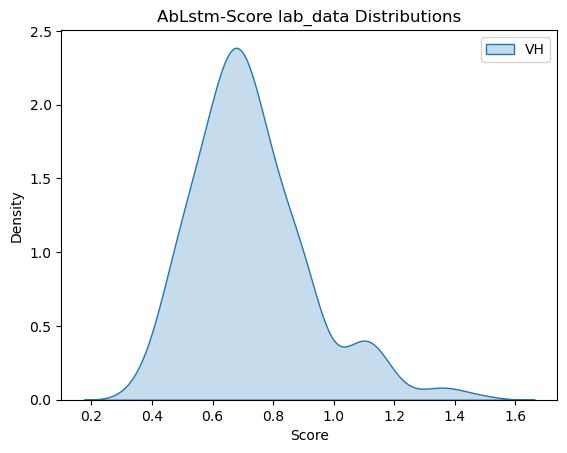

In [36]:
sns.kdeplot(h_lab_score, fill=True, label='VH')
# sns.kdeplot(l_lab_score, fill=True, label='VL')

plt.xlabel("Score")
plt.ylabel("Density")
plt.title("AbLstm-Score lab_data Distributions")
plt.legend()

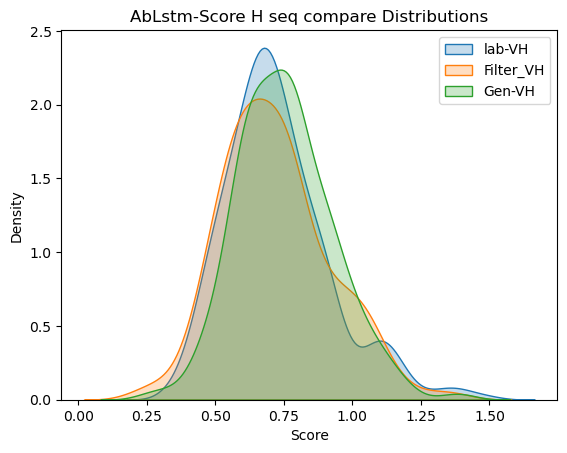

In [12]:
sns.kdeplot(h_lab_score, fill=True, label='lab-VH')
sns.kdeplot(filter_h_score, fill=True, label='Filter_VH')
sns.kdeplot(h_score, fill=True, label='Gen-VH')

plt.xlabel("Score")
plt.ylabel("Density")
plt.title("AbLstm-Score H seq compare Distributions")
plt.legend()

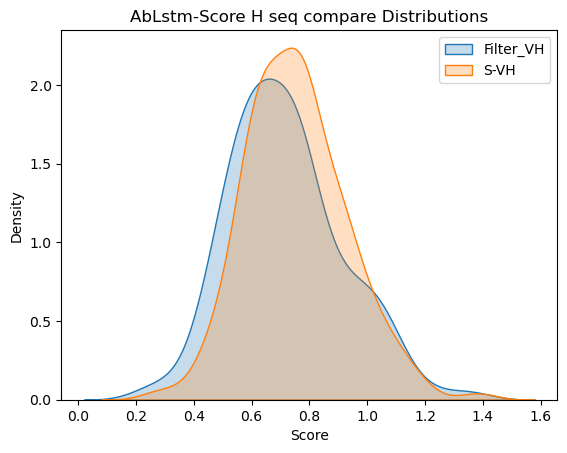

In [39]:
# sns.kdeplot(h_lab_score, fill=True, label='T-VH')
sns.kdeplot(filter_h_score, fill=True, label='Filter_VH')
sns.kdeplot(h_score, fill=True, label='S-VH')

plt.xlabel("Score")
plt.ylabel("Density")
plt.title("AbLstm-Score H seq compare Distributions")
plt.legend()

In [132]:
test_seq = h_seq_df[12]

In [135]:
test_chain = Chain(test_seq, scheme='imgt')
test_chain.print_tall()

       H1 Q     CDR1 H27 G     CDR2 H56 I          H84 T    CDR3 H109 N
       H2 V     CDR1 H28 Y     CDR2 H57 H          H85 S    CDR3 H110 F
       H3 Q     CDR1 H29 T     CDR2 H58 P          H86 T    CDR3 H111 Y
       H4 L     CDR1 H30 F     CDR2 H59 S          H87 A    CDR3 H111A T
       H5 V     CDR1 H35 I     CDR2 H62 D          H88 Y    CDR3 H111B V
       H6 Q     CDR1 H36 N     CDR2 H63 S          H89 M    CDR3 H112B N
       H7 S     CDR1 H37 Y     CDR2 H64 A          H90 E    CDR3 H112A A
       H8 G     CDR1 H38 W     CDR2 H65 T          H91 L    CDR3 H112 W
       H9 A          H39 M          H66 R          H92 S    CDR3 H113 Y
      H11 E          H40 N          H67 L          H93 S    CDR3 H114 Y
      H12 V          H41 W          H68 N          H94 L    CDR3 H115 F
      H13 K          H42 V          H69 Q          H95 R    CDR3 H116 D
      H14 K          H43 R          H70 S          H96 S    CDR3 H117 Y
      H15 P          H44 Q          H71 F          H97 E    

In [143]:
results = number(test_seq, scheme='imgt')

In [144]:
results

([((1, ' '), 'Q'),
  ((2, ' '), 'V'),
  ((3, ' '), 'Q'),
  ((4, ' '), 'L'),
  ((5, ' '), 'V'),
  ((6, ' '), 'Q'),
  ((7, ' '), 'S'),
  ((8, ' '), 'G'),
  ((9, ' '), 'A'),
  ((10, ' '), '-'),
  ((11, ' '), 'E'),
  ((12, ' '), 'V'),
  ((13, ' '), 'K'),
  ((14, ' '), 'K'),
  ((15, ' '), 'P'),
  ((16, ' '), 'G'),
  ((17, ' '), 'A'),
  ((18, ' '), 'S'),
  ((19, ' '), 'V'),
  ((20, ' '), 'K'),
  ((21, ' '), 'V'),
  ((22, ' '), 'S'),
  ((23, ' '), 'C'),
  ((24, ' '), 'K'),
  ((25, ' '), 'A'),
  ((26, ' '), 'S'),
  ((27, ' '), 'G'),
  ((28, ' '), 'Y'),
  ((29, ' '), 'S'),
  ((30, ' '), 'F'),
  ((31, ' '), '-'),
  ((32, ' '), '-'),
  ((33, ' '), '-'),
  ((34, ' '), '-'),
  ((35, ' '), 'I'),
  ((36, ' '), 'G'),
  ((37, ' '), 'Y'),
  ((38, ' '), 'F'),
  ((39, ' '), 'M'),
  ((40, ' '), 'N'),
  ((41, ' '), 'W'),
  ((42, ' '), 'V'),
  ((43, ' '), 'R'),
  ((44, ' '), 'Q'),
  ((45, ' '), 'A'),
  ((46, ' '), 'P'),
  ((47, ' '), 'G'),
  ((48, ' '), 'M'),
  ((49, ' '), 'G'),
  ((50, ' '), 'L'),
  ((51, '

In [145]:
lab_mouse_df = lab_df[lab_df['Origin/Engineering'] == 'mouse']

In [146]:
lab_mouse_df

,Origin/Engineering,name,HC sequence source,HC sequence,LC sequence source,LC sequence,Source,Target sequence,Target sequence source,note
0,mouse,3A3,WO2011112566_20,EVKLEESGGGLVQPGGSMKLSCVASGFTFSNFWMDWVRQSPEKGLE...,WO2011112566_22,DIVMTQSHKFMSTSVGDRVSITCKASQDVSTDVAWYQQKPGQSPKL...,WO2011112566,MAAALFVLLGFALLGTHGASGAAGTVFTTVEDLGSKILLTCSLNDS...,WO2011112566_1,Sample
6,mouse,MAK195,WO2011127141_22,QVQLKESGPGLVAPSQSLSITCTVSGFSLTDYGVNWVRQPPGKGLE...,WO2011127141_23,DIVMTQSHKFMSTTVGDRVSITCKASQAVSSAVAWYQQKPGQSPKL...,WO2011127141,MSTESMIRDVELAEEALPKKTGGPQGSRRCLFLSLFSFLIVAGATT...,Uniprot:P01375,Sample
12,mouse,31#,WO2022057651_1,EVQLQQPGADLVRPGASVKLSCKASGYTFTDYWMNWVKLRPGQGLE...,WO2022057651_2,DVVITQSPSSLAMSVGQKVTMSCKSSQSLLNTNSQKNYLAWYQQKP...,WO2022057651A1,MPLSLGAEMWGPEAWLLLLLLLASFTGRCPAGELETSDVVTVVLGQ...,Uniprot:Q96NY8,Sample
14,mouse,56#,WO2022057651_19,QVQLKESGPGLVKPSQSLSLTCTVTGYSITSDYDWHWIRHFPGNML...,WO2022057651_20,DIQLTQSPAILSVSPGERVSFSCRASQNIGTSIHWYQHRTNGSPRL...,NaN,MPLSLGAEMWGPEAWLLLLLLLASFTGRCPAGELETSDVVTVVLGQ...,Uniprot:Q96NY8,Sample
16,mouse,74#,WO2022057651_37,EVQLQQPGAELVRPGASVKLSCKASGYTFINYWMNWVKQRPGQGLE...,WO2022057651_38,DIVITQSPSSLAMSVGQKVTMSCKSSQTLLNSNTQKNYLAWYQQKP...,NaN,MPLSLGAEMWGPEAWLLLLLLLASFTGRCPAGELETSDVVTVVLGQ...,Uniprot:Q96NY8,Sample
...,...,...,...,...,...,...,...,...,...,...
989,mouse,muA1,US20070231333A1_2,MDWLWNLLFLMAAAQSIQAQIQLVQSGPELKKPGETVKISCKASGY...,US20070231333A1_4,MKSQTQVFVFLLLCVSGAHGSIVMTQTPKFLLVSAGDRVTITCKAS...,US20070231333A1,MPGGCSRGPAAGDGRLRLARLALVLLGWVSSSSPTSSASSFSSSAP...,Uniprot:Q13641,NaN
992,mouse,mu515H7,US9090686B2_8,EVNLVESGGGLVQPGGSLRLSCATSGFTFTDNYMSWVRQPPGKALE...,US9090686B2_7,DIVMSQSPSSLAVSAGEKVTMSCKSSQSLFNSRTRKNYLAWYQQKP...,US9090686B2,MEGISIYTSDNYTEEMGSGDYDSMKEPCFREENANFNKIFLPTIYS...,Uniprot:P61073,NaN
996,mouse,mu16B5,US20170233487A1_29,EVQLQQSGAELVKPGASVRLSCTTSGFNIKDIYMHWVKQRPEQGLE...,US20170233487A1_25,DIVMSQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKP...,US20170233487A1,MMKTLLLFVGLLLTWESGQVLGDQTVSDNELQEMSNQGSKYVNKEI...,Uniprot:P10909,NaN
998,mouse,21B12,US20170233487A1_37,QIQLVQSGPELKKPGETVKISCKASGYTFTNYGMHWVKQAPGKGLK...,US20170233487A1_33,DIVMSQSPSSLAVSVGEKVTMSCKSSQSLLYSSNQKNYLAWYQQRP...,US20170233487A1,MMKTLLLFVGLLLTWESGQVLGDQTVSDNELQEMSNQGSKYVNKEI...,Uniprot:P10909,NaN


In [148]:
lab_humanized_df

,Origin/Engineering,name,HC sequence source,HC sequence,LC sequence source,LC sequence,Source,Target sequence,Target sequence source,note
1,humanized,h3A3-5,WO2011112566_27,EVQLVESGGGLVQPGGSLRLSCAASGFTFSNFWMDWVRQAPGKGLE...,WO2011112566_33,DIQMTQSPSSLSASVGDRVTITCKASQDVSTDVAWYQQKPGKAPKL...,NaN,MAAALFVLLGFALLGTHGASGAAGTVFTTVEDLGSKILLTCSLNDS...,WO2011112566_1,Sample
2,NaN,h3A3-6,WO2011112566_28,EVQLVESGGGLVQPGGSLRLSCAASGFTFSNFWMDWVRQAPGKGLE...,WO2011112566_33,DIQMTQSPSSLSASVGDRVTITCKASQDVSTDVAWYQQKPGKAPKL...,NaN,MAAALFVLLGFALLGTHGASGAAGTVFTTVEDLGSKILLTCSLNDS...,WO2011112566_1,Sample
3,NaN,h3A3-8,WO2011112566_27,EVQLVESGGGLVQPGGSLRLSCAASGFTFSNFWMDWVRQAPGKGLE...,WO2011112566_34,DIQMTQSPSSLSASVGDRVTITCKASQDVSTDVAWYQQKPGKSPKL...,NaN,MAAALFVLLGFALLGTHGASGAAGTVFTTVEDLGSKILLTCSLNDS...,WO2011112566_1,Sample
4,NaN,h3A3-9,WO2011112566_28,EVQLVESGGGLVQPGGSLRLSCAASGFTFSNFWMDWVRQAPGKGLE...,WO2011112566_34,DIQMTQSPSSLSASVGDRVTITCKASQDVSTDVAWYQQKPGKSPKL...,NaN,MAAALFVLLGFALLGTHGASGAAGTVFTTVEDLGSKILLTCSLNDS...,WO2011112566_1,Sample
5,NaN,h3A3-12,WO2011112566_28,EVQLVESGGGLVQPGGSLRLSCAASGFTFSNFWMDWVRQAPGKGLE...,WO2011112566_35,DIVMTQSPSSLSASVGDRVTITCKASQDVSTDVAWYQQKPGKSPKL...,NaN,MAAALFVLLGFALLGTHGASGAAGTVFTTVEDLGSKILLTCSLNDS...,WO2011112566_1,Sample
...,...,...,...,...,...,...,...,...,...,...
994,humanized,hz515H7 VH1 D76N VL2.2,US9090686B2_64,EVQLVESGGGLVQPGRSLRLSCTASGFTFTDNYMSWVRQAPGKGLE...,US9090686B2_82,DIVMTQSPDSLAVSLGERATMSCKSSQSLFNSRTRKNYLAWYQQKP...,US9090686B2,MEGISIYTSDNYTEEMGSGDYDSMKEPCFREENANFNKIFLPTIYS...,Uniprot:P61073,NaN
995,humanized,hz515H7 VH1 D76N VL2.3,US9090686B2_64,EVQLVESGGGLVQPGRSLRLSCTASGFTFTDNYMSWVRQAPGKGLE...,US9090686B2_83,DIVMTQSPDSLAVSLGERATMSCKSSQSLFNSRTRKNYLAWYQQKP...,US9090686B2,MEGISIYTSDNYTEEMGSGDYDSMKEPCFREENANFNKIFLPTIYS...,Uniprot:P61073,NaN
997,humanized,hu16B5,US20170233487A1_7,QVQLVQSGAEVKKPGATVKISCKVSGFNIKDIYMHWVQQAPGKGLE...,US20170233487A1_8,DIVMTQSPDSLAVSLGERATINCKSSQSLLNSRTRKNYLAWYQQKP...,US20170233487A1,MMKTLLLFVGLLLTWESGQVLGDQTVSDNELQEMSNQGSKYVNKEI...,Uniprot:P10909,NaN
999,humanized,hu21B12,US20170233487A1_17,QVQLVQSGSELKKPGASVKVSCKASGYTFTNYGMHWVRQAPGQGLE...,US20170233487A1_18,DIVMTQSPDSLAVSLGERATINCKSSQSLLYSSNQKNYLAWYQQKP...,US20170233487A1,MMKTLLLFVGLLLTWESGQVLGDQTVSDNELQEMSNQGSKYVNKEI...,Uniprot:P10909,NaN


In [158]:
lab_df

Origin/Engineering                                                humanized
name                                                                 h3A3-5
HC sequence source                                          WO2011112566_27
HC sequence               EVQLVESGGGLVQPGGSLRLSCAASGFTFSNFWMDWVRQAPGKGLE...
LC sequence source                                          WO2011112566_33
LC sequence               DIQMTQSPSSLSASVGDRVTITCKASQDVSTDVAWYQQKPGKAPKL...
Source                                                                  NaN
Target sequence           MAAALFVLLGFALLGTHGASGAAGTVFTTVEDLGSKILLTCSLNDS...
Target sequence source                                       WO2011112566_1
note                                                                 Sample
Name: 1, dtype: object

In [164]:
human_idx

Index([   1,    2,    3,    4,    5,    7,    8,    9,   10,   11,
       ...
        987,  988,  990,  991,  993,  994,  995,  997,  999, 1001],
      dtype='int64', length=646)

In [170]:
# Make sure the humanization length is equal.
mouse_idx = lab_mouse_df.index
human_idx = lab_humanized_df.index
equal_count = 0
no_equal_count = 0
for idx, m_idx in enumerate(mouse_idx):
    if idx+1 < len(mouse_idx):
        next_m_idx = mouse_idx[idx+1]
        repect_human_index = [h_idx for h_idx in human_idx if m_idx < h_idx < next_m_idx]
        raw_mouse_length = len(Chain(lab_df.iloc[m_idx]['HC sequence'], scheme='imgt').seq)
        repect_human_length = []
        for hu_idx in repect_human_index:
            humanized_length = len(Chain(lab_df.iloc[hu_idx]['HC sequence'], scheme='imgt').seq)
            repect_human_length.append(humanized_length)
            if raw_mouse_length == humanized_length:
                equal_count += 1
            else:
                no_equal_count += 1
        print(f'Mouse length: {raw_mouse_length}', f'Human length: {repect_human_length}')
    else:
        repect_human_index = [h_idx for h_idx in human_idx if m_idx < h_idx]
        raw_mouse_length = len(Chain(lab_df.iloc[m_idx]['HC sequence'], scheme='imgt').seq)
        repect_human_length = []
        for hu_idx in repect_human_index:
            humanized_length = len(Chain(lab_df.iloc[hu_idx]['HC sequence'], scheme='imgt').seq)
            repect_human_length.append(humanized_length)
            if raw_mouse_length == humanized_length:
                equal_count += 1
            else:
                no_equal_count += 1
        print(f'Mouse length: {raw_mouse_length}', f'Human length: {repect_human_length}')
        
    
print(f'Equal Count: {equal_count}')
print(f'Un Equal Count: {no_equal_count}')
print(f'Sum humanized Seq: {equal_count + no_equal_count}')
print(f'Equal ratio: {equal_count / (equal_count + no_equal_count)}')
print(f'Un Equal ratio: {no_equal_count / (equal_count + no_equal_count)}')
# Equal Count: 589
# Un Equal Count: 57
# Sum humanized Seq: 646
# Equal ratio: 0.9117647058823529
# Un Equal ratio: 0.08823529411764706

Mouse length: 116 Human length: [116, 116, 116, 116, 116]
Mouse length: 117 Human length: [117, 117, 117, 117, 117]
Mouse length: 120 Human length: [120]
Mouse length: 117 Human length: [119]
Mouse length: 124 Human length: [124]
Mouse length: 120 Human length: [120, 120, 120, 120, 120]
Mouse length: 120 Human length: [120]
Mouse length: 116 Human length: [116]
Mouse length: 117 Human length: [117]
Mouse length: 119 Human length: [119, 119]
Mouse length: 118 Human length: [118]
Mouse length: 121 Human length: [121]
Mouse length: 122 Human length: [122]
Mouse length: 114 Human length: [114]
Mouse length: 119 Human length: [119, 119, 119, 119, 119]
Mouse length: 123 Human length: [123]
Mouse length: 120 Human length: [120]
Mouse length: 120 Human length: [120]
Mouse length: 117 Human length: [117]
Mouse length: 115 Human length: [116, 116, 116]
Mouse length: 124 Human length: [124]
Mouse length: 117 Human length: [117]
Mouse length: 121 Human length: [121]
Mouse length: 121 Human length:

NameError: name 'lab_mouse_df' is not defined